# **Import Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('./datasets/airline.csv')
holiday = pd.read_csv('./datasets/dim_date_proposed.csv')


## **Data Cleaning**

### **Holiday Dataset**

In [2]:
#remove non-holidays
holiday_cleaned = holiday[holiday['holiday_us'].notnull()]

#include only holidays we need in the years in airline.csv (1987 - 2008)
holiday_cleaned = holiday_cleaned[(holiday_cleaned['cal_year'] >= 1987) & (holiday_cleaned['cal_year'] <= 2008)]

#remove unncessary columns
holiday_cleaned = holiday_cleaned[['day_dt','holiday_us']]

#add year column
holiday_cleaned["year"] = holiday_cleaned["day_dt"].str[-4:]
holiday_cleaned["year"].astype(int)

#change the format of day_dt column from mm/dd/yyyy to dd/mm/yyyy
holiday_cleaned['day_dt'] = pd.to_datetime(holiday_cleaned['day_dt'], dayfirst=True)

holiday_cleaned

C:\Users\zhenx\AppData\Local\Temp\ipykernel_10040\2208522972.py:15: UserWarning: Parsing '11/26/1987' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  holiday_cleaned['day_dt'] = pd.to_datetime(holiday_cleaned['day_dt'], dayfirst=True)
C:\Users\zhenx\AppData\Local\Temp\ipykernel_10040\2208522972.py:15: UserWarning: Parsing '12/24/1987' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  holiday_cleaned['day_dt'] = pd.to_datetime(holiday_cleaned['day_dt'], dayfirst=True)
C:\Users\zhenx\AppData\Local\Temp\ipykernel_10040\2208522972.py:15: UserWarning: Parsing '12/25/1987' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  holiday_cleaned['day_dt'] = pd.to_datetime(holiday_cleaned['day_dt'], dayfirst=True)
C:\Users\zhenx\AppData\Local\Temp\ipykernel_10040\2208522972.py:15: UserWarning: Parsing '12/31/1987' in MM/DD/YYYY format. Provide form

,day_dt,holiday_us,year
14610,1987-01-01,New Years Day,1987
14628,1987-01-19,MLK Day,1987
14656,1987-02-16,Presidents Day,1987
14754,1987-05-25,Memorial Day,1987
14794,1987-04-07,Independence Day,1987
...,...,...,...
22595,2008-11-11,Veterans Day,2008
22611,2008-11-27,Thanksgiving Day,2008
22638,2008-12-24,Christmas Eve,2008
22639,2008-12-25,Christmas Day,2008


#### **airline.csv Dataset**

In [3]:
#create full_date column
df1 = df
df1["full_date"] = df["DayofMonth"].astype(str) + "/" + df["Month"].astype(str) + "/" + df["Year"].astype(str)
df1["full_date"] = pd.to_datetime(df["full_date"], format = "%d/%m/%Y", dayfirst=True) #this doesn't change the date properly for some reason, but it works well enough to be able to work w the data

#create is_holiday column
df1["is_holiday"] = df1["full_date"].isin(holiday_cleaned["day_dt"])

#remove rows with ArrTime > 2400
df1 = df1[(df1['ArrTime'] <= 2400)]
df1 = df1[(df1['DepTime'] <= 2400)]



df1


#martin removed cancelled flights (only begins in 2003, 1.63 %, )

,ActualElapsedTime,AirTime,ArrDelay,ArrTime,CRSArrTime,CRSDepTime,CRSElapsedTime,CancellationCode,Cancelled,CarrierDelay,...,Origin,SecurityDelay,TailNum,TaxiIn,TaxiOut,UniqueCarrier,WeatherDelay,Year,full_date,is_holiday
0,154.0,122.0,90.0,1850.0,1720,1455,145.0,NaN,0,0.0,...,ORD,0.0,N293AA,8.0,24.0,AA,0.0,2006,2006-06-21,False
1,159.0,125.0,59.0,1703.0,1604,1510,114.0,NaN,0,NaN,...,DTW,NaN,N8921E,19.0,15.0,NW,NaN,1997,1997-09-16,False
3,70.0,NaN,80.0,20.0,2300,2100,60.0,NaN,0,NaN,...,MDW,NaN,NaN,NaN,NaN,ML (1),NaN,1991,1991-02-05,False
4,150.0,135.0,5.0,2030.0,2025,1740,165.0,NaN,0,NaN,...,PHL,NaN,N512AU,3.0,12.0,US,NaN,1997,1997-02-01,False
5,110.0,NaN,10.0,1450.0,1440,1300,100.0,NaN,0,NaN,...,BDL,NaN,NaN,NaN,NaN,CO,NaN,1989,1989-02-21,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9882792,65.0,38.0,5.0,1835.0,1830,1720,70.0,NaN,0,NaN,...,DTW,NaN,89339E,5.0,22.0,9E,NaN,2008,2008-10-02,False
9882793,115.0,93.0,5.0,906.0,0,0,119.0,NaN,0,NaN,...,DFW,NaN,N579AA,9.0,13.0,AA,NaN,1997,1997-12-25,True
9882794,137.0,NaN,-10.0,708.0,718,550,148.0,NaN,0,NaN,...,MCO,NaN,NaN,NaN,NaN,DL,NaN,1992,1992-08-30,False
9882795,76.0,61.0,-4.0,736.0,740,620,80.0,NaN,0,NaN,...,ONT,NaN,N639@@,3.0,12.0,WN,NaN,2001,2001-05-03,False


In [4]:
pd.to_datetime("2006-06-21", format = "%Y/%m/%d", dayfirst=True)

df2 = df1

start_date = '1999-12-25 00:00:00.000000000'
end_date = '1999-12-26 00:00:00.000000000'

df2[df2["full_date"].between(start_date,end_date)]


,ActualElapsedTime,AirTime,ArrDelay,ArrTime,CRSArrTime,CRSDepTime,CRSElapsedTime,CancellationCode,Cancelled,CarrierDelay,...,Origin,SecurityDelay,TailNum,TaxiIn,TaxiOut,UniqueCarrier,WeatherDelay,Year,full_date,is_holiday
21138,48.0,18.0,7.0,758.0,751,710,41.0,NaN,0,NaN,...,LEX,NaN,N543DA,8.0,22.0,DL,NaN,1999,1999-12-25,True
24040,124.0,109.0,-5.0,2102.0,2107,1905,122.0,NaN,0,NaN,...,CLT,NaN,N425US,3.0,12.0,US,NaN,1999,1999-12-25,True
31112,129.0,113.0,21.0,1423.0,1402,1037,145.0,NaN,0,NaN,...,DEN,NaN,N205AA,5.0,11.0,AA,NaN,1999,1999-12-26,False
31727,115.0,72.0,19.0,1314.0,1255,1115,100.0,NaN,0,NaN,...,ANC,NaN,N745AS,5.0,38.0,AS,NaN,1999,1999-12-26,False
34797,172.0,159.0,-20.0,2128.0,2148,1640,188.0,NaN,0,NaN,...,DEN,NaN,N336UA,5.0,8.0,UA,NaN,1999,1999-12-25,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9860447,66.0,36.0,-2.0,1628.0,1630,1530,60.0,NaN,0,NaN,...,PHL,NaN,N590US,6.0,24.0,US,NaN,1999,1999-12-25,True
9870242,55.0,43.0,-12.0,1050.0,1102,955,67.0,NaN,0,NaN,...,PHL,NaN,N855US,3.0,9.0,US,NaN,1999,1999-12-26,False
9871416,151.0,123.0,-13.0,1056.0,1109,830,159.0,NaN,0,NaN,...,LGA,NaN,N637DL,8.0,20.0,DL,NaN,1999,1999-12-26,False
9871688,82.0,62.0,-6.0,814.0,820,645,95.0,NaN,0,NaN,...,DCA,NaN,N983DL,10.0,10.0,DL,NaN,1999,1999-12-25,True


# **Data Visualization**

### Line Graph (NEW)

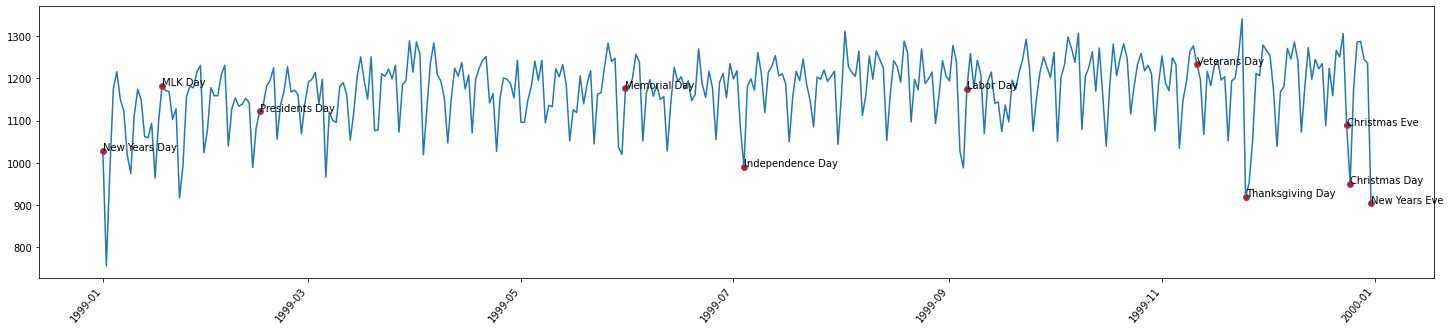

In [5]:
def day_of_year_list(timestamps):
    day_of_year_list = [timestamp.dayofyear for timestamp in timestamps]
    day_of_year_list = [day - 1 for day in day_of_year_list]
    return day_of_year_list

#creating  line graph
df_year = 1999

plot_data = df1.groupby("full_date")["full_date"].count()
plot_df = pd.DataFrame({'full_date':plot_data.index,'flight_count':plot_data.values})
plot_df_1999 = plot_df[plot_df["full_date"].dt.year == df_year]

x_axis = plot_df_1999["full_date"]
y_axis = plot_df_1999["flight_count"]

#creating holiday markers
holiday1 = holiday[holiday["cal_year"] == df_year]
holiday2 = holiday1[["holiday_us", "day_of_year"]]
holiday_label_list = []
holiday_labels = []
for index, row in holiday2.iterrows():
    if pd.isna(row["holiday_us"]):
        holiday_label_list.append("")
    else:
        holiday_label_list.append(row["holiday_us"])
        holiday_labels.append(row["day_of_year"]-1)

plt.figure(figsize=(25, 5))
plt.plot(x_axis, y_axis,  marker="o", markevery=holiday_labels, mfc = "r")
for x, y, text in zip(x_axis, y_axis, holiday_label_list):
    plt.text(x, y, text)

plt.xticks(rotation=50, ha="right")
plt.show()


### Analysis

In [6]:

from datetime import timedelta

def get_week_dates(timestamps):
    holiday_dates = {}
    for timestamp in timestamps:
        holiday_dates[timestamp] = []
        holiday_dates[timestamp].append(timestamp)
        for i in range(1,8):
            i_days_before = timestamp - timedelta(days=i)
            i_days_after = timestamp + timedelta(days=i)
            holiday_dates[timestamp].append(i_days_before)
            holiday_dates[timestamp].append(i_days_after)
    return holiday_dates

def remove_duplicate(timestamps):
    timestamp_list = []
    for timestamp in timestamps:
        if timestamp not in timestamp_list:
            timestamp_list.append(timestamp)
    return timestamp_list

                                                                                                                                                                            

result_df = pd.DataFrame(columns=["year","holiday w/ highest effect","diff_high", "holiday w/ worst effect","diff_low"])

year_list = list(range(1988,2008))
for year in year_list:
    plot_df_year = plot_df[plot_df["full_date"].dt.year == year]
    holiday1 = holiday[holiday["cal_year"] == year]

    analysis_df1 = holiday1[["day_dt","holiday_us"]][holiday1[["day_dt","holiday_us"]]["holiday_us"].notna()]
    analysis_df2 =  pd.to_datetime(analysis_df1['day_dt'],dayfirst=True)
    analysis_df2_list = analysis_df2.to_list()

    analysis_df2_dict = get_week_dates(analysis_df2_list)

    analysis_df3 = pd.DataFrame(columns=['holiday_date','flight_count_average_2_weeks','max','min'])

    for holidayx, date_list in analysis_df2_dict.items():
        holiday_flight_total = 0
        holiday_max = 0
        holiday_min = 1000000
        for date2 in date_list:
            day_flight_total = plot_df["flight_count"][plot_df["full_date"]== date2]
            day_flight_total = day_flight_total.iloc[0]
            holiday_flight_total += day_flight_total
            if day_flight_total > holiday_max:
                holiday_max = day_flight_total
            if day_flight_total < holiday_min:
                holiday_min = day_flight_total
            flight_count_average = holiday_flight_total/15
            flight_count_average = flight_count_average.round()
        temp_df = pd.DataFrame({'holiday_date':[holidayx],'flight_count_average_2_weeks':[flight_count_average], 'max':[holiday_max], 'min':[holiday_min]})
        analysis_df3 = pd.concat([analysis_df3,temp_df])
        

    diff_column = pd.DataFrame(columns=['diff_from_avg'])
    for index, row in analysis_df3.iterrows():
        diff_from_avg = row[1] - plot_df_year["flight_count"].mean()
        temp_df = pd.DataFrame({'diff_from_avg':[diff_from_avg]})
        diff_column = pd.concat([diff_column,temp_df])

    analysis_df3 = pd.concat([analysis_df3, diff_column], axis=1)

    highest_holiday = ""
    lowest_holiday = ""
    highest_holiday_diff = 0
    lowest_holiday_diff = 100000
    for index, row in analysis_df3.iterrows():
        diff = row[4]
        holiday_date = row[0]
        if diff < lowest_holiday_diff:
            lowest_holiday_diff = diff
            lowest_holiday = holiday_date
        if diff > highest_holiday_diff:
            highest_holiday_diff = diff
            highest_holiday = holiday_date

    # print("Mean of all daily flights for year " + str(year) + ": " + str(plot_df_year["flight_count"].mean()))
    # print("Min of all daily flights for year " + str(year) + ": " + str(plot_df_year["flight_count"].min()))
    # print("Max of all daily flights for year " + str(year) + ": " + str(plot_df_year["flight_count"].max()))

    temp_df = pd.DataFrame({'year':[year],'holiday w/ highest effect':[highest_holiday],'diff_high':[highest_holiday_diff], 'holiday w/ worst effect':[lowest_holiday], "diff_low":[lowest_holiday_diff]})
    result_df = pd.concat([result_df,temp_df])



C:\Users\zhenx\AppData\Local\Temp\ipykernel_10040\3028161526.py:32: UserWarning: Parsing '11/24/1988' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  analysis_df2 =  pd.to_datetime(analysis_df1['day_dt'],dayfirst=True)
C:\Users\zhenx\AppData\Local\Temp\ipykernel_10040\3028161526.py:32: UserWarning: Parsing '12/24/1988' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  analysis_df2 =  pd.to_datetime(analysis_df1['day_dt'],dayfirst=True)
C:\Users\zhenx\AppData\Local\Temp\ipykernel_10040\3028161526.py:32: UserWarning: Parsing '12/25/1988' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  analysis_df2 =  pd.to_datetime(analysis_df1['day_dt'],dayfirst=True)
C:\Users\zhenx\AppData\Local\Temp\ipykernel_10040\3028161526.py:32: UserWarning: Parsing '12/31/1988' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for con

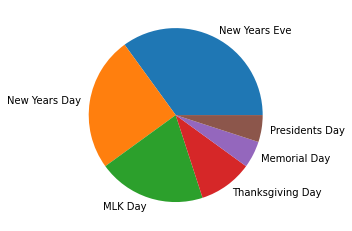

In [27]:
result_df1 = result_df
result_df1 = result_df1.reset_index(drop=True)
for index, row in result_df1.iterrows():
    holiday_name_high = holiday_cleaned.loc[holiday_cleaned["day_dt"]==row[1], "holiday_us"].iloc[0]
    result_df1.at[index, 'holiday w/ highest effect'] = holiday_name_high
    holiday_name_low = holiday_cleaned.loc[holiday_cleaned["day_dt"]==row[3], "holiday_us"].iloc[0]
    result_df1.at[index, 'holiday w/ worst effect'] = holiday_name_low
result_df1
result_df1['holiday w/ worst effect'].value_counts()


result_df2 = result_df1['holiday w/ worst effect'].value_counts().rename_axis("holiday w/ worst effect").reset_index(name="count")
high_holiday_list = result_df2["holiday w/ worst effect"].to_list()
high_count_list = result_df2["count"].to_list()

y = np.array(high_count_list)
mylabels = high_holiday_list

plt.pie(y, labels = mylabels)
plt.show() 

## Line Graph (OLD)


In [8]:
# #function for markers
# def day_of_year(date_str):
#     month, day, year = map(int, date_str.split('/'))
#     days_in_month = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
#     if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
#         days_in_month[2] += 1  # Leap year adjustment
#     return days_in_month[month - 1] + day - 1  # Subtract 1 to convert to 0-based indexing

                                                                                                                                                                                                 

# year_to_visualize = 1999
# year_to_visualize_string = "1999"
# df_year = df1[(df1['Year'] == year_to_visualize)]

# flights_total = df_year.groupby('full_date').size()

# holidays = df_year[df_year['is_holiday'] == True]
# holidays = holidays.groupby('full_date').size()

# holiday_df = holidays.to_frame()
# holiday_df.reset_index(inplace=True)

# holiday_list = holiday_df['full_date'].tolist()
# print(holiday_list)
# day_of_year_list = [day_of_year(date_str) for date_str in holiday_list]
# # print(day_of_year_list)

# plt.figure(figsize=(20, 12))
# flights_total.plot(kind='line', marker='o', mfc = "r", color='blue', linestyle='-',markevery=day_of_year_list)

# plt.xlabel('Time')
# plt.ylabel('Number of Flights')
# plt.title('Number of Domestic Flights from 1987 to 2008 with Holidays Highlighted')
# plt.grid(True)
# plt.legend(['Number of Flights', 'Holiday'])

# plt.show()